# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.92KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

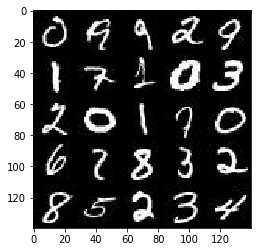

In [2]:
show_n_images = 25
import helper
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

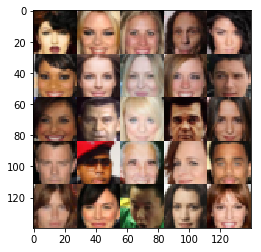

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learn_rate")  
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'): 
   return tf.maximum(x, alpha * x, name=name)


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    is_train=True
    keep_prob=0.5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x1 = tf.layers.dropout(x1, rate=1-keep_prob, training=is_train)
        relu1 = leaky_relu(x1, alpha)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x2 = tf.layers.dropout(x2, rate=1-keep_prob, training=is_train)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leaky_relu(x2, alpha)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x3 = tf.layers.dropout(x3, rate=1-keep_prob, training=is_train)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(x3, alpha)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    keep_prob=0.5 #https://github.com/soumith/ganhacks
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1,256, 4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x2 = tf.layers.dropout(x2, rate=1-keep_prob, training=is_train)
        #x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x3 = tf.layers.dropout(x3, rate=1-keep_prob, training=is_train)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha)
        # 14x14x128 now
        
        # First fully connected layer
        #x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        #x1 = tf.reshape(x1, (-1, 7, 7, 256))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        #x3 = tf.layers.conv2d_transpose(x1, 128, 4, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now         
            
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x(channels) now
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    #From https://github.com/soumith/ganhacks
    real_random_smooth = np.random.uniform(0.8, 1.0)
    fake_random_smooth = 0.0 #np.random.uniform(0.0, 0.3)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * real_random_smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) + fake_random_smooth))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print_every = 10
    show_every = 100
    alpha = 0.2 
    steps = 0
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    
    with tf.Session() as sess:

        input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
        d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, alpha=alpha)
        d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
        sess.run(tf.global_variables_initializer())
            
        #Train on epochs
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Double value of batch_images
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    #Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 0.7190
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 1.8410... Generator Loss: 0.3166
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.9424


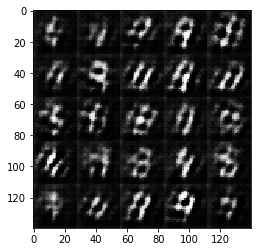

Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 1.1436
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 1.2128
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.9711


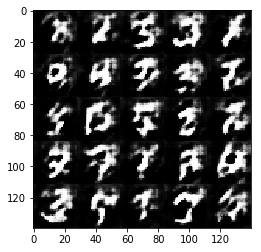

Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 1.4819
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 1.3954
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 1.2825
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 1.0482
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.8479


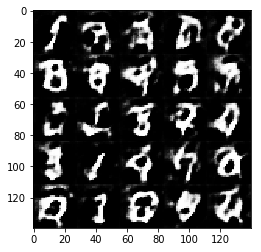

Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 1.5739
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 1.2386


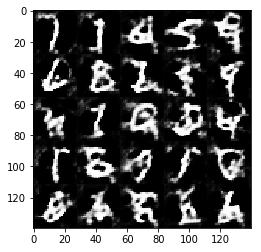

Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 1.0946
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.6561


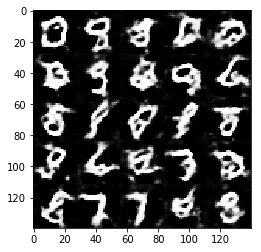

Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.9939
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.1887
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 1.2821


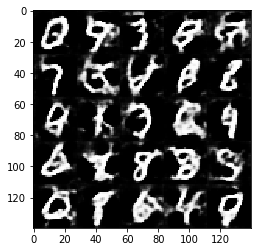

Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 1.2203
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.9606
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 1.1221
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.6508
Epoch 1/2... Discriminator Loss: 133.0409... Generator Loss: 26.3091
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 2.6868


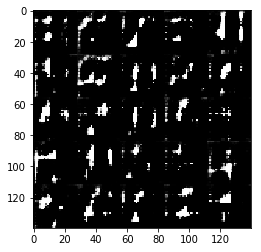

Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 1.2387
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 1.3554
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 1.4865
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 1.0733


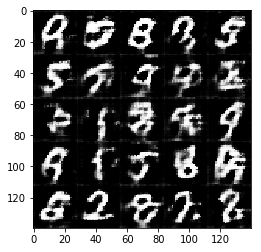

Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 1.0996
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 1.0610


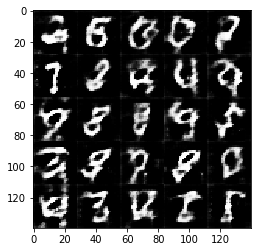

Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 1.1946
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 1.1853
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 1.0795


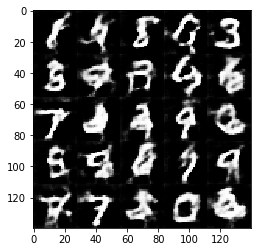

Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 1.1837
Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 1.0864
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 1.1804
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 1.0354


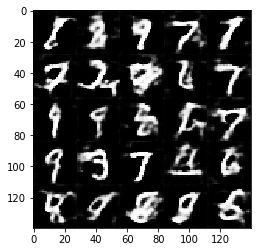

Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 1.1228
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 1.2248
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 1.0094
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 1.1717... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 1.1273


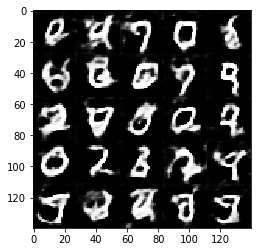

Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 1.0612
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 1.0466
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 1.2012
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 1.1042


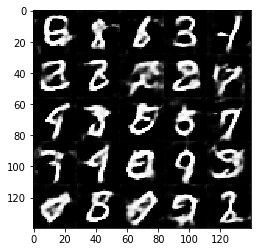

Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 1.2291
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 1.1244
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 1.1727
Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 1.1945... Generator Loss: 1.1324
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 1.1372
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 1.2532


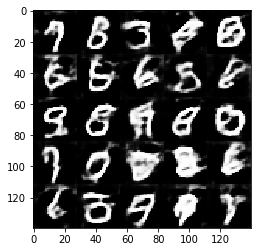

Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 1.1598
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.9885
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 1.0336
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 1.1535
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 1.1028
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 1.2271


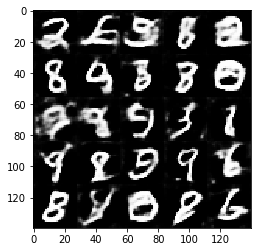

Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 1.0721
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 1.1317
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 1.1108
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 1.0451


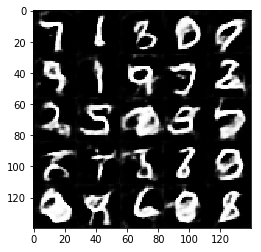

Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 1.2144
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 1.0989
Epoch 2/2... Discriminator Loss: 1.2015... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 1.1109
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 1.1730


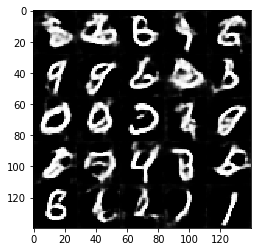

Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 1.0044
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 1.1328
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 1.0607
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 1.2023


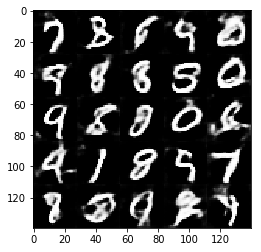

Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 1.1276
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 1.1259
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 1.1233
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 1.1172
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 1.2278


In [28]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.8730... Generator Loss: 0.2822
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.9374
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.3792


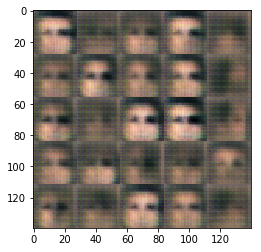

Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.8556... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.5087


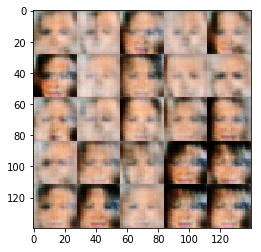

Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.9439


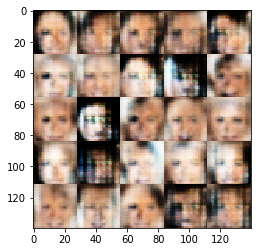

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6579


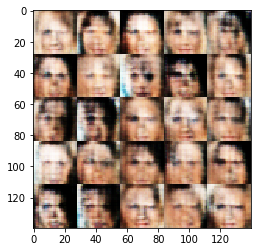

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.1223


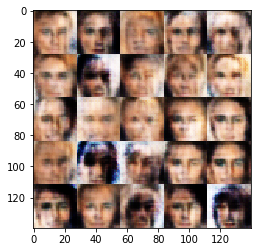

Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8821


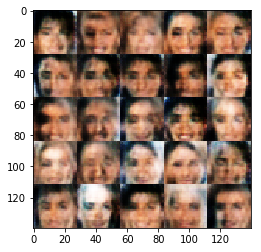

Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.8396


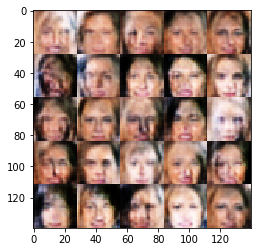

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.0407


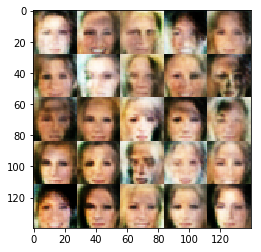

Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9173


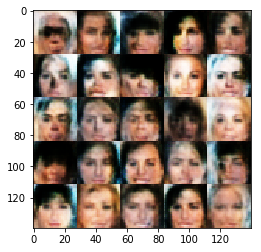

Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8514


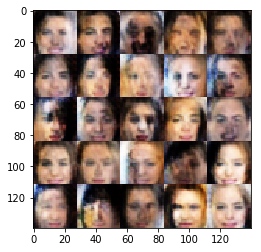

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8832


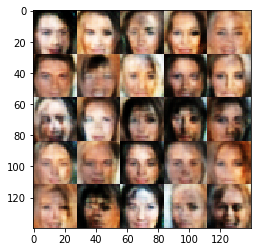

Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8978


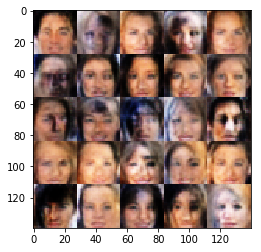

Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8380


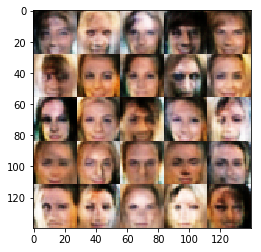

Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 1.0698


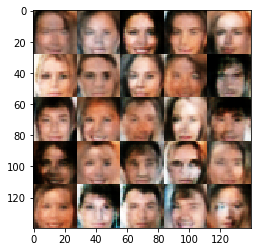

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8123


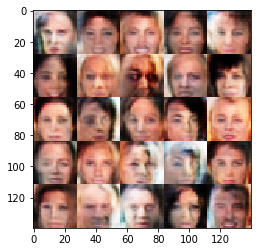

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9803


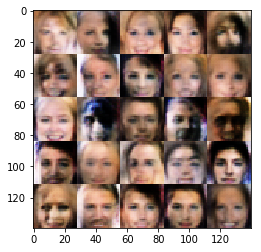

Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8145


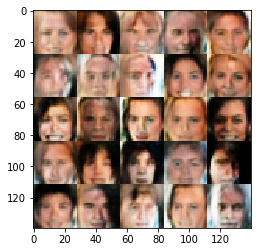

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.8993


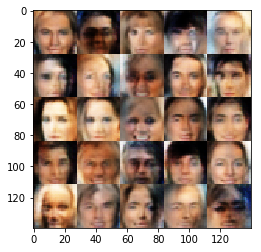

Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9718


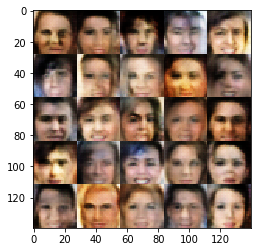

Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9421


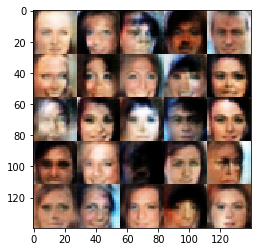

Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.9981


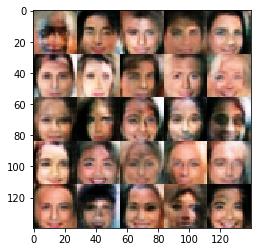

Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 1.0935


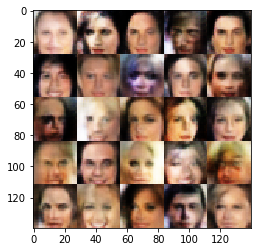

Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8182


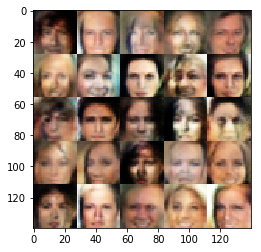

Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8106


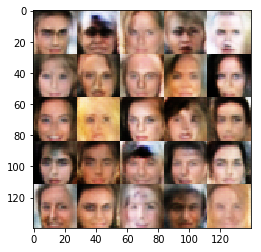

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.4096
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 3.2324... Generator Loss: 2.2681


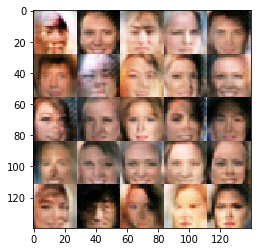

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.9304


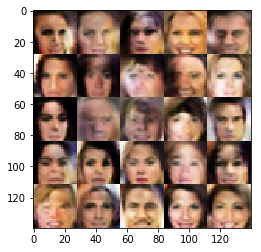

Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8071


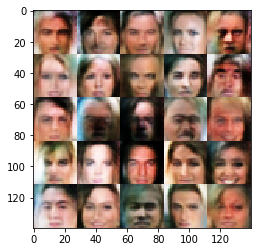

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9237


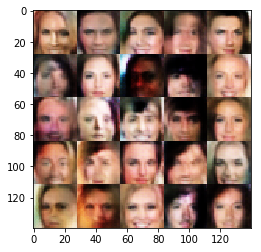

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8883


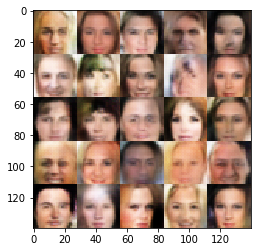

Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7123


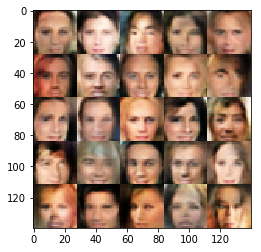

Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.8836


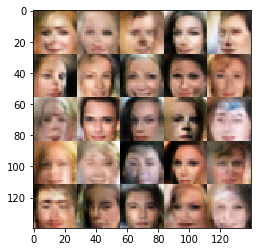

Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9723


In [29]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.